In [1]:
import numpy as np
import pickle
import pathlib
import pyimfit
from astropy.io import fits
import corner
import matplotlib.pyplot as plt
import pandas as pd
from photutils import profiles
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

imageFile = "../fit/agn.fits"
imageAGN = fits.getdata(imageFile)

epsf = fits.getdata("../psfConstruction/psfResults/epsf.fits")
psf1 = fits.getdata("psf1.fits")

In [2]:
with open("../fit/fitResults/J1215+1344_fit.pkl", "rb") as file:
    d0 = pickle.load(file)  
"""
modelName = ["1 psf+sersic same center", "2 psf+sersic same center","1 psf+sersic diff center", "2 psf+sersic diff center"]
dfs = [pd.DataFrame([d0['paramNames'][n],d0['bestfit_n1'][n]['params']],index=['',modelName[n]]).T for n in range(4)]
pd.concat(dfs, axis=1).fillna('')
"""

'\nmodelName = ["1 psf+sersic same center", "2 psf+sersic same center","1 psf+sersic diff center", "2 psf+sersic diff center"]\ndfs = [pd.DataFrame([d0[\'paramNames\'][n],d0[\'bestfit_n1\'][n][\'params\']],index=[\'\',modelName[n]]).T for n in range(4)]\npd.concat(dfs, axis=1).fillna(\'\')\n'

# True param radial profile and intensity

Radial profile integrated AGN up: 2447.443
Radial profile integrated AGN down: 2685.517
Intensity of whole image:25506.391


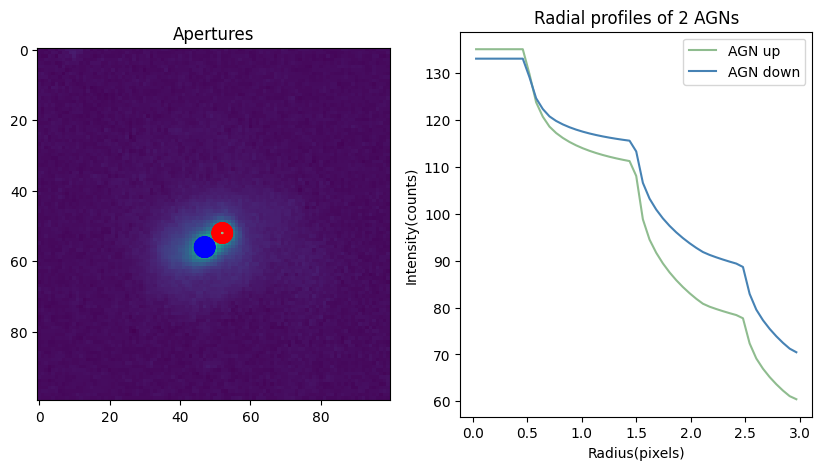

In [185]:
# plotting radial profiles
centeru = [52,52] #up
centerd = [47,56] #down
n = 1 # plot every n aperture
w = 3
r = np.linspace(0,w)

fig, ax = plt.subplots(1,2, figsize=(10,5))

agnup = profiles.RadialProfile(imageAGN,xycen=centeru,radii=r)
agndp = profiles.RadialProfile(imageAGN,xycen=centerd,radii=r)

im0 = ax[0].imshow(imageAGN)
[agnup.apertures[i].plot(ax=ax[0],color='r', lw=0.5) for i in range(len(agnup.apertures))]
[agndp.apertures[i].plot(ax=ax[0],color='b', lw=0.5) for i in range(len(agndp.apertures))]
#psf1.normalize("max")

agnup.apertures[int(3)].plot(ax=ax[0],color='darkseagreen', lw=0.5)

ax[1].plot(agnup.radius, agnup.profile, color='darkseagreen', label="AGN up")
ax[1].plot(agndp.radius, agndp.profile, color='steelblue', label="AGN down")
ax[1].legend()

[ax[i].set_title(["Apertures", "Radial profiles of 2 AGNs"][i]) for i in range(2)]
ax[1].set_xlabel("Radius(pixels)")
ax[1].set_ylabel("Intensity(counts)");

print(f"Radial profile integrated AGN up: {np.sum(agnup.profile*agnup.area):.3f}")
print(f"Radial profile integrated AGN down: {np.sum(agndp.profile*agndp.area):.3f}")
print(f"Intensity of whole image:{np.sum(imageAGN):.3f}")

In [6]:
# PSF
psf = {'I_tot' : [1500, 0, 1e4]}
psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}
funcset_dict_psf0 = {'X0': [50,0,100], 'Y0': [50,0,100], 
                'function_list': [psf_dict]}
model= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':[funcset_dict_psf0]})
fitter = pyimfit.Imfit(model, psf=psf1)


# make galaxy models
I_tot is the integrated intensity. Feeding position at 50,70 gives model image at 49,69

In [2]:
def find_highest_indices(arr):
    """returns a tuple of ys, xs - indices of pixels with highest counts"""
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices

def makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                 sigma, sigma_lim):
    """Return Sersic, PSF, and Gaussian model parameter dictionary"""
    # Sersic
    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    # PSF
    psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]]}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}
    # Gaussians
    gaussian = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]], 
                'I_0':[I_ss, Iss_lim[0],Iss_lim[1]], 'sigma':[sigma, sigma_lim[0], sigma_lim[1]]}
    gaussian_dict = {'name': "Gaussian", 'label': "gaussian", 'parameters': gaussian}
    return sersic_dict, psf_dict, gaussian_dict

def galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, 
                    Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim, midf):
    """Returns a function set dictionary with keys as model name, 
       values as model function set"""
    sersic_dict, psf_dict, gaussian_dict = makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                 sigma, sigma_lim)
    #========function dictionary
    # separate psf
    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    # separate sersic
    funcset_dict_sersic0 = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xsslim[0],Xsslim[1]], 'Y0': [Yss1,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # overall sersic
    funcset_dict_sersicT = {'X0': [midf,Xsslim[0],Xsslim[1]], 'Y0': [midf,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # separate gaussian
    funcset_dict_gaussian0 = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [gaussian_dict]}
    funcset_dict_gaussian1 = {'X0': [Xss1,Xsslim[0],Xsslim[1]], 'Y0': [Yss1,Ysslim[0],Ysslim[1]], 
                   'function_list': [gaussian_dict]}
    # same center psf+sersic
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    # same center psf+gaussian
    funcset_dict_psfgaus0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,gaussian_dict]}
    funcset_dict_psfgaus1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,gaussian_dict]}
    # overall gaussian
    funcset_dict_gaussianT = {'X0': [midf,Xsslim[0],Xsslim[1]], 'Y0': [midf,Ysslim[0],Ysslim[1]], 
                   'function_list': [gaussian_dict]}
    
    #========model dict
    funcset = {
        "1psf": [funcset_dict_psf0],
        "1psf+sersic,sameCenter": [funcset_dict_psfser0],
        "1psf+gaussian,sameCenter": [funcset_dict_psfgaus0],
        
        "2psf": [funcset_dict_psf0, funcset_dict_psf1],
        "2psf+sersic,sameCenter": [funcset_dict_psfser0,funcset_dict_psfser1],
        "2psf+gaussian,sameCenter": [funcset_dict_psfgaus0,funcset_dict_psfgaus1],
        
        "1psf+sersic,diffCenter":[funcset_dict_psf0,funcset_dict_sersic0],
        "1psf+gaussian,diffCenter": [funcset_dict_psf0,funcset_dict_gaussian0],
        
        "2psf+sersic,diffCenter":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "2psf+gaussian,diffCenter":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_gaussian0,funcset_dict_gaussian1],
        
        "2psf,overall Sersic": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersicT],
        "2psf+sersic,sameCenter,overall Sersic": [funcset_dict_psfser0,funcset_dict_psfser1,funcset_dict_sersicT],
        "2psf+sersic,diffCenter,overall Sersic":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,
                                                 funcset_dict_sersic1,funcset_dict_sersicT],
        
        "2psf,overall Sersic": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersicT],
        "2psf+sersic,sameCenter,overall Sersic": [funcset_dict_psfser0,funcset_dict_psfser1,funcset_dict_sersicT],
        "2psf+sersic,diffCenter,overall Sersic":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,
                                                 funcset_dict_sersic1,funcset_dict_sersicT],
        
        "2psf,overall Gaussian": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_gaussianT],
        "2psf+gaussian,sameCenter,overall Gaussian": [funcset_dict_gaussianT,funcset_dict_psfgaus0,funcset_dict_psfgaus1],
        "2psf+gaussian,diffCenter,overall Gaussian":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_gaussian0,
                                                 funcset_dict_gaussian1,funcset_dict_gaussianT],
        
        "2psf+gaussian,sameCenter,overall Sersic": [funcset_dict_psfgaus0,funcset_dict_psfgaus1,funcset_dict_sersicT],
        "2psf+sersic,sameCenter,overall Gaussian": [funcset_dict_psfser0,funcset_dict_psfser1,funcset_dict_gaussianT]
    }
    return funcset


def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                sigma, sigma_lim,midf):
    """return a dictionary of galaxy model with keys as model name"""
    funcset = galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim,midf);
    models = {}
    for model in funcset:
        models[model]= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset[model]})
    return models

ys,xs = find_highest_indices(imageAGN)
yc = np.sum(ys)/2
xc = np.sum(xs/2)
Imax = imageAGN.max()
itot=1500


#create galaxy models with n=1
models_n1 = galaxy_model(X0=xs[0], Y0=ys[0], 
                         X1=xs[1], Y1=ys[1], 
                         Xss0=xs[0], Yss0=ys[0], 
                         Xss1=xs[1], Yss1=ys[1],
                         Xlim=[0,100], Ylim=[0,100], Xsslim = [xc-15,xc+15], Ysslim=[yc-15,yc+15],
                         PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                         PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                         Iss_lim=[0.1,Imax], rss_lim=[0.1,100], Itot_lim=[0.1,1e4],
                         sigma = 5, sigma_lim = [1,20])

"""
for i in models_n1.keys():
    print(i.upper())
    print(models_n1[i])
    print("========================")
""";
models_n1.keys()

# do fit and plot 

In [5]:
def dofit_no_oversp(modelName, dataImage=imageAGNcrop, skylevel = 654.63, solver="NM"):
    """do fit with not oversampled psf
       plot """
    fitter = pyimfit.Imfit(models_n1[modelName],psf=psf1)
    fitter.loadData(dataImage, gain=9.942e-1, read_noise=0.22, original_sky=skylevel)
    fitter.doFit(solver)
    fitConfig = fitter.getModelDescription()
    fitModelImage = fitter.getModelImage()
    fitResult = fitter.getFitResult()
    param_names = fitter.numberedParameterNames
    return fitConfig, fitModelImage, fitResult, param_names

"""models = list(models_n1.keys())
configs = []
modelIms = []
fitResults = []
pnames= []

best7mn = [models[bestind[i]] for i in range(len(bestind))]

for modelName in tqdm(best7mn, desc="Fitting models"):
    config, modelIm, fitRes, pname  = dofit_no_oversp(modelName)
    configs.append(config)
    modelIms.append(modelIm)
    fitResults.append(fitRes)
    pnames.append(pname)"""
    


'models = list(models_n1.keys())\nconfigs = []\nmodelIms = []\nfitResults = []\npnames= []\n\nbest7mn = [models[bestind[i]] for i in range(len(bestind))]\n\nfor modelName in tqdm(best7mn, desc="Fitting models"):\n    config, modelIm, fitRes, pname  = dofit_no_oversp(modelName)\n    configs.append(config)\n    modelIms.append(modelIm)\n    fitResults.append(fitRes)\n    pnames.append(pname)'

Fitting models:  67%|████████████████████████████████████████████▋                      | 12/18 [10:34<09:52, 98.81s/it]
*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit 

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimization)!
*** Terminating the fit...

*** NaN-valued fit statistic detected (N-M optimizatio

Fitting models: 100%|███████████████████████████████████████████████████████████████████| 18/18 [24:44<00:00, 82.49s/it]


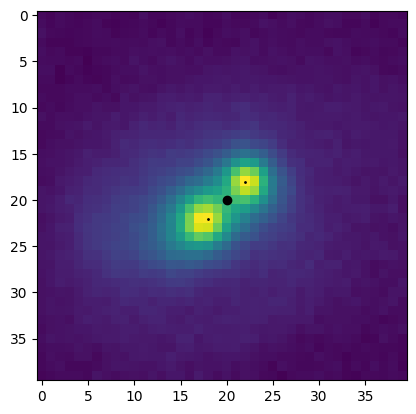

In [6]:
#plt.imshow(imageAGN)
#plt.plot(50,54,"ko",markersize=2)
px=20
imageAGNcrop = imageAGN[54-px:54+px,50-px:50+px]
plt.imshow(imageAGNcrop)
plt.plot(px,px, "ko")
;

ys,xs = find_highest_indices(imageAGNcrop)
yc = np.sum(ys)/2
xc = np.sum(xs/2)
Imax = imageAGN.max()
itot=1500
framelim = imageAGNcrop.shape[0]
midF=framelim//2

models_n1 = galaxy_model(X0=xs[0], Y0=ys[0], 
                         X1=xs[1], Y1=ys[1], 
                         Xss0=xs[0], Yss0=ys[0], 
                         Xss1=xs[1], Yss1=ys[1],
                         Xlim=[0,framelim], Ylim=[0,framelim], Xsslim = [0,framelim], Ysslim=[0,framelim],
                         PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                         PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                         Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                         sigma = 5, sigma_lim = [1,20],midf=midF)

plt.imshow(imageAGN[54-px:54+px,50-px:50+px])
[plt.plot(xs[i],ys[i], "ko",markersize=1) for i in range(2)]


models = list(models_n1.keys())
configs = []
modelIms = []
fitResults = []
pnames= []

#best7mn = [models[bestind[i]] for i in range(len(bestind))][:5]

for modelName in tqdm(models, desc="Fitting models"):
    config, modelIm, fitRes, pname  = dofit_no_oversp(modelName, dataImage=imageAGNcrop)
    configs.append(config)
    modelIms.append(modelIm)
    fitResults.append(fitRes)
    pnames.append(pname)

63.79074799201445
X0_1: 13.885
Y0_1: 17.646
PA_1: 241.284
ell_1: 0.472
I_0_1: 116.586
sigma_1: 6.132
I_tot_2: 6946.911
PA_2: 328.191
X0_2: 18.312
Y0_2: 13.785
PA_3: 339.584
ell_3: 0.353
I_0_3: 101.020
sigma_3: 1.820
I_tot_4: 9590.476
PA_4: 299.284


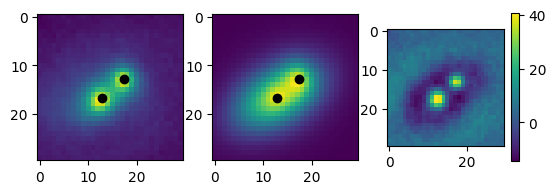

In [291]:
n=3
m = modelIms[n]
pname = pnames[n]
res = fitResults[n].params
fs = fitResults[n].fitStat
print(fs)
[print(f"{pname[i]}: {res[i]:.3f}") for i in range(len(pname))]
#[plt.plot(xs[i],ys[i], "ko",markersize=1) for i in range(2)];
fig,ax = plt.subplots(1,3)
im = [ax[i].imshow([imageAGNcrop, m, imageAGNcrop-m][i]) for i in range(3)]

dic = dict(zip(pname, res))
cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])

[[ax[j].plot([cenup,cendown][i][0],[cenup,cendown][i][1],"ko") for i in range(2)] for j in range(2)]
fig.colorbar(im[2],ax=ax[2],shrink=0.4);

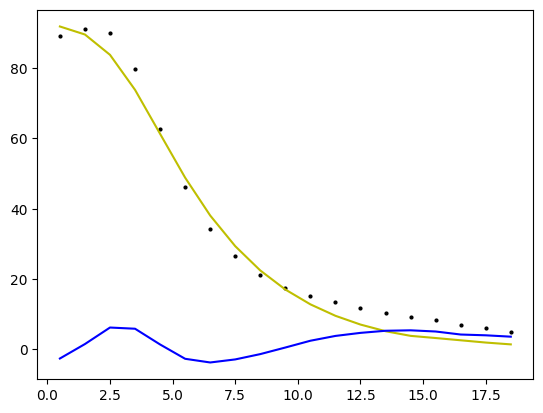

In [292]:
agn = profiles.RadialProfile(imageAGNcrop,xycen=[xc,yc],radii=np.arange(20))
mRP = profiles.RadialProfile(m,xycen=(cenup+cendown)/2,radii=np.arange(20))
plt.plot(agn.radius, agn.profile, 'ko', label="data",markersize=2)
plt.plot(mRP.radius, mRP.profile, color='y', label="model")
plt.plot(mRP.radius, agn.profile-mRP.profile, color='b', label="residual")

In [8]:
savedata = {}
savedata['modelNames'] = models
savedata['configs'] = configs
savedata['modelImage'] = modelIms
savedata['fitResults'] = fitResults
savedata['paramNames'] = pnames


pickle.dump(savedata,open("fit_psf20_psfFirst.pkl","wb"))

# fit result analysis

In [22]:
with open("fit_psf20_bulgeFirst.pkl", 'rb') as file:
    d = pickle.load(file)
d.keys()

dict_keys(['modelNames', 'configs', 'modelImage', 'fitResults', 'paramNames'])

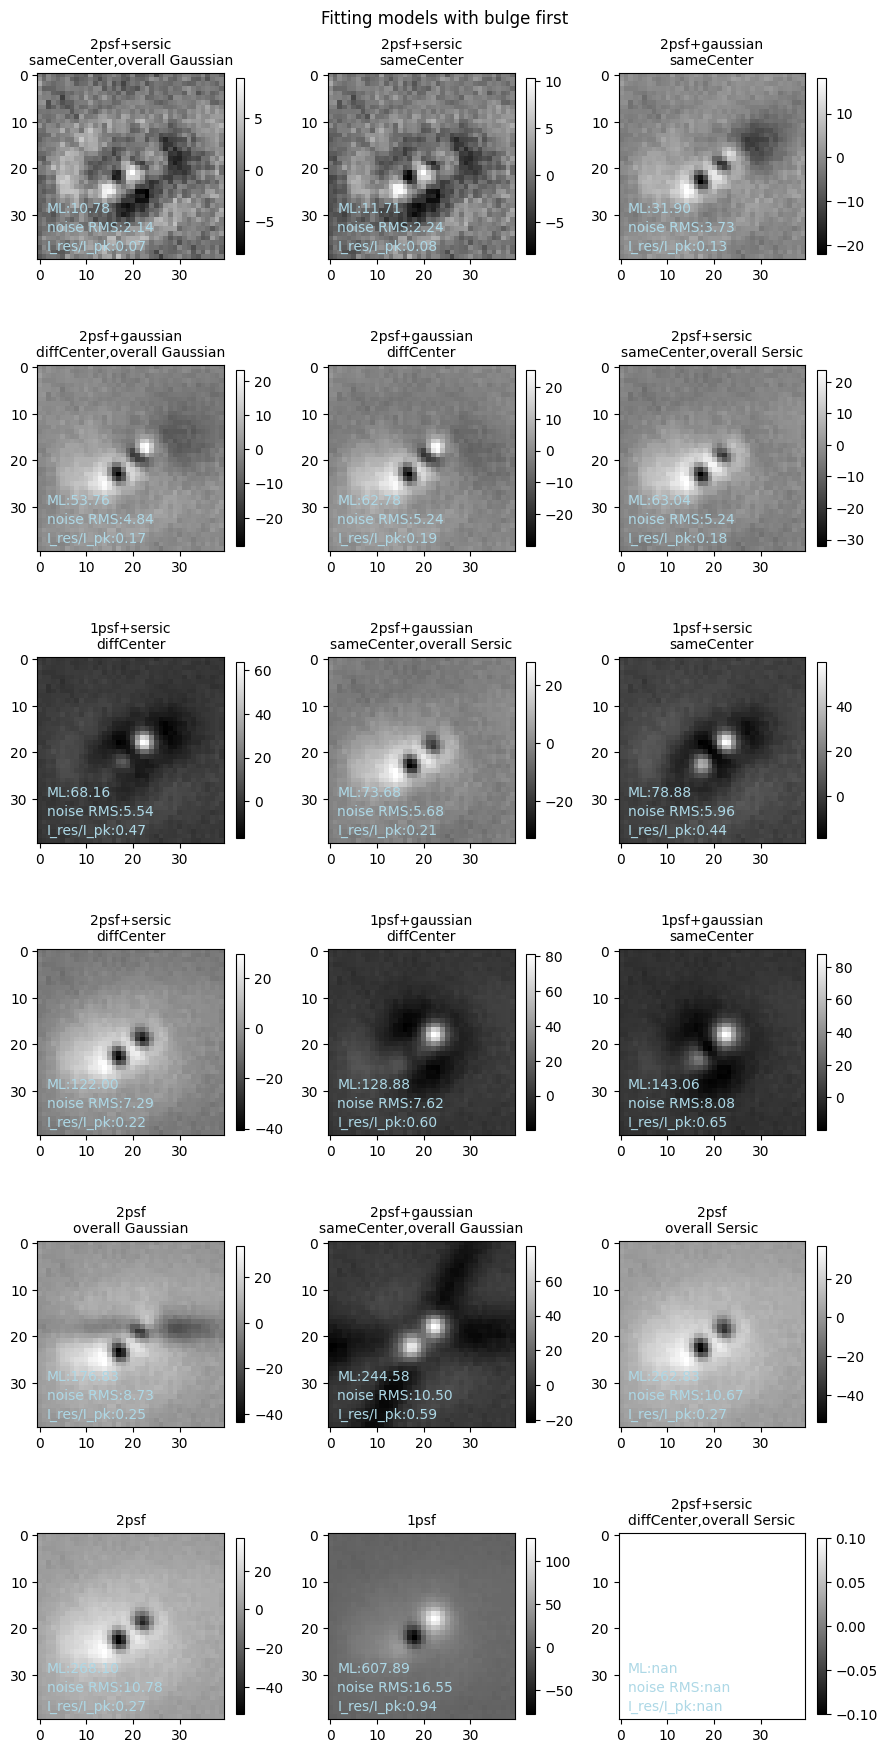

In [25]:
fig,ax = plt.subplots(6,3,figsize=(9,18))
ax = ax.ravel()
fitStats = [d['fitResults'][i].fitStat for i in range(18)]
modNum = 18
for i, j in zip(np.argsort(fitStats),np.arange(modNum)):
    resi = imageAGNcrop-d['modelImage'][i]
    im = ax[j].imshow(resi,cmap="gray")
    title = d['modelNames'][i]
    title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
    ax[j].set_title(title, fontsize=10)
    fig.colorbar(im, ax=ax[j], shrink=0.7)
    rmsNoise = np.sqrt(np.sum(resi**2)/(resi.shape[0]**2))
    iRatio = np.max(resi)/np.max(imageAGNcrop)
    ax[j].text(0.05, 0.25, f"ML:{fitStats[i]:.2f}", transform=ax[j].transAxes, fontsize=10, color='lightblue')
    ax[j].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j].transAxes, fontsize=10, color='lightblue')
    ax[j].text(0.05, 0.05, f"I_res/I_pk:{iRatio:.2f}", transform=ax[j].transAxes, fontsize=10, color='lightblue')

fig.suptitle("Fitting models with bulge first")
fig.tight_layout();

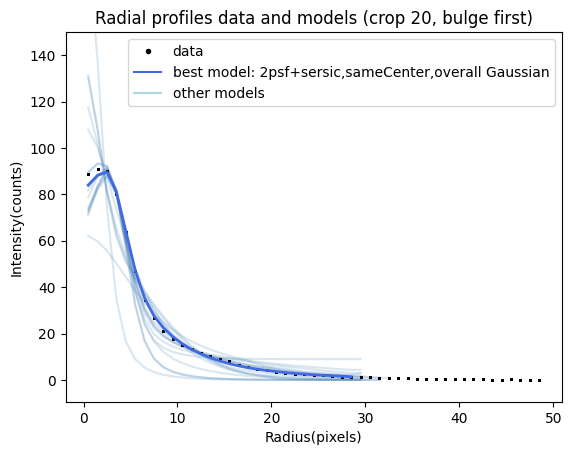

In [27]:
bestind = np.argsort(fitStats)
fig,ax = plt.subplots()
for i in range(modNum):
    param_names=d['paramNames'][i]
    param_vals = d['fitResults'][i].params
    dic = dict(zip(param_names, param_vals))
    if d['modelNames'][i][0] == "1":
        cen = [dic["X0_1"]-1, dic['Y0_1']-1]
    else:
        cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
        cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])
        cen = (cenup+cendown)/2
    agn = profiles.RadialProfile(imageAGN,xycen=[49.5,54],radii=np.arange(50))
    mRP = profiles.RadialProfile(d['modelImage'][i],xycen=cen,radii=np.arange(50))
    ax.plot(agn.radius, agn.profile, 'ko', label="data",markersize=1)
    if i==bestind[0]:
        ax.plot(mRP.radius, mRP.profile, color='royalblue', label="best 5 models", lw=2)
    else:
        ax.plot(mRP.radius, mRP.profile, color='steelblue', label="other models", alpha=0.2)
    #ax.plot(mRP.radius, agn.profile-mRP.profile, color='b', label="residual")
ax.set_title("Radial profiles data and models (crop 20, bulge first)")
ax.set_xlabel("Radius(pixels)")
ax.set_ylabel("Intensity(counts)") 
ax.set_ylim(ymax=150)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5, label='data'),
    plt.Line2D([0], [0], color='royalblue', label='best model: '+d['modelNames'][bestind[0]]),
    plt.Line2D([0], [0], color='lightblue', label='other models')
]

ax.legend(handles=legend_elements)

In [328]:
def printFitResult(modelName):
    """format fit result to fidget with param values"""
    i = np.where(np.array(d['modelNames']) == modelName)[0][0]
    param_vals = d['fitResults'][i].params
    for i in param_vals:
        print(f"{i:.2f}, ", end="")
        
        
def plotNewP(modelName,newP,skylevel=654.63):
    """plot data, model, residual using new parameter set"""
    i = np.where(np.array(d['modelNames']) == modelName)[0][0]
    bf = d['fitResults'][i].params
    model = d['configs'][i]
    fitter = pyimfit.Imfit(model,psf=psf1)
    fitter.loadData(imageAGN, gain=9.942e-1, read_noise=0.22, original_sky=skylevel)
    modelImage = fitter.getModelImage(newParameters = newP)
    fig,ax = plt.subplots(1,3,figsize=(12,5))
    im0 = ax[0].imshow(imageAGN)
    #[ax[i].plot(newP[0]-1,newP[1]-1,"ro",markersize=0.5,markerfacecolor='none') for i in range(3)]
    #[ax[i].plot(newP[pos2_ind[0]]-1,newP[pos2_ind[1]]-1,"bo",markersize=0.5,markerfacecolor='none') for i in range(3)]
    im1 = ax[1].imshow(modelImage)
    im2 =ax[2].imshow(imageAGN-modelImage)
    [fig.colorbar([im0,im1,im2][i],ax=ax[i],shrink=0.7) for i in range(3)]
    [ax[i].set_title(["agn", "model", "residual"][i]) for i in range(3)];
    print("bf: ", fitter.computeFitStatistic(bf))
    print("new: ", fitter.computeFitStatistic(newP))
    
    
    
def plotRadial(m,modelName,dic,sep,imageAGN,data_center):
    """plot model residual,
        apertures,
        radial profile and residual"""
    # plot model image and apertures
    a = 10
    if sep:
        fig, ax = plt.subplots(1,4, figsize=(12,4))
    else:
        fig, ax = plt.subplots(1,3, figsize=(10,4))
    im0 = ax[0].imshow(imageAGN-m)
    ax[0].set_title("Residuals")
    im1 = ax[1].imshow(m)
    ax[1].set_title(f"Every {a} apertures")
    [fig.colorbar([im0,im1][i],ax=ax[i],shrink=0.7) for i in range(2)]
    cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
    cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])
    cen = (cenup+cendown)/2
    if sep:
        # create AGN profiles separately
        agn0p = profiles.RadialProfile(imageAGN,xycen=centeru,radii=np.arange(50))
        agn1p = profiles.RadialProfile(imageAGN,xycen=centerd,radii=np.arange(50))
        # create model profiles
        m0 = profiles.RadialProfile(m,xycen=cenup,radii=np.arange(50))
        m1 = profiles.RadialProfile(m,xycen=cendown,radii=np.arange(50))
        [agn0p.apertures[int(a*i)].plot(ax=ax[1],color='darkseagreen', lw=0.5) for i in range(50//a)]
        [agn1p.apertures[int(a*i)].plot(ax=ax[1],color='steelblue', lw=0.5) for i in range(50//a)]
        # plot agn & model radial profiles
        ax[2].plot(agn0p.radius, agn0p.profile, 'ko', label="AGN up true",markersize=2)
        ax[3].plot(agn1p.radius, agn1p.profile, 'ro', label="AGN down true",markersize=2)
        ax[2].plot(m0.radius, m0.profile, color='y', label="AGN up model")
        ax[3].plot(m1.radius, m1.profile, color='steelblue', label="AGN down model")
        for i in [2,3]:
            ax[i].legend()
            ax[i].set_title("Radial profiles of 2 AGNs")
            ax[i].set_xlabel("Radius(pixels)")
            ax[i].set_ylabel("Intensity(counts)") 
    else:
        agn = profiles.RadialProfile(imageAGN,xycen=data_center,radii=np.arange(50))
        mRP = profiles.RadialProfile(m,xycen=cen,radii=np.arange(50))
        [agn.apertures[int(a*i)].plot(ax=ax[1],color='darkseagreen', lw=0.5) for i in range(50//a)]
        ax[2].plot(agn.radius, agn.profile, 'ko', label="data",markersize=2)
        ax[2].plot(mRP.radius, mRP.profile, color='y', label="model")
        ax[2].plot(mRP.radius, agn.profile-mRP.profile, color='b', label="residual")
        ax[2].legend()
        ax[2].set_title("Radial profiles of 2 AGNs")
        ax[2].set_xlabel("Radius(pixels)")
        ax[2].set_ylabel("Intensity(counts)") 
    fig.suptitle(modelName)
    fig.tight_layout();
    
def plotFit(m,dic,modelName,imageAGN):
    fig,ax = plt.subplots(1,3, figsize=(6,3))
    im = [ax[i].imshow([imageAGN, m, imageAGN-m][i]) for i in range(3)]
    cenup = np.array([dic["X0_1"]-1, dic['Y0_1']-1])
    cendown = np.array([dic["X0_2"]-1, dic['Y0_2']-1])
    [[ax[j].plot([cenup,cendown][i][0],[cenup,cendown][i][1],"ko") for i in range(2)] for j in range(2)]
    fig.colorbar(im[2],ax=ax[2],shrink=0.4);

def getResult(modelName, imageAGN,data_center, sep=False):
    i = np.where(np.array(d['modelNames']) == modelName)[0][0]
    param_names=d['paramNames'][i]
    param_vals = d['fitResults'][i].params
    model = d['modelImage'][i]
    ml =d['fitResults'][i].fitStat
    dic = dict(zip(param_names, param_vals))
    print("Model: "+str(modelName))
    print("\n")
    [print(f"{param_names[i]}: {param_vals[i]:.3f}") for i in range(len(param_names))]
    print("\n")
    print("ML:", ml)
    plotRadial(model,modelName,dic,sep,imageAGN,data_center)
    plotFit(model,dic,modelName,imageAGN)

In [28]:
pd.set_option('display.max_colwidth',1)
best5i = np.argsort([d['fitResults'][i].fitStat for i in range(18)])[:5]
dfs = [pd.DataFrame([d['paramNames'][n],d['fitResults'][n].params],index=['',d['modelNames'][n]]).T for n in best5i]
dfs = pd.concat(dfs, axis=1).fillna('')
newcol = [' \n '.join(col.split(',', 1)) if len(col) > 15 else col for col in dfs.columns]
dfs.columns = newcol
dfs

,,"2psf+sersic \n sameCenter,overall Gaussian",,2psf+sersic \n sameCenter,,2psf+gaussian \n sameCenter,,"2psf+gaussian \n diffCenter,overall Gaussian",,2psf+gaussian \n diffCenter
0,X0_1,18.359295,X0_1,18.358552,X0_1,18.277507,X0_1,18.084568,X0_1,17.999997
1,Y0_1,23.216297,Y0_1,23.211101,Y0_1,23.440893,Y0_1,23.588755,Y0_1,23.644857
2,PA_1,252.057928,PA_1,251.266987,PA_1,298.793623,I_tot_1,3444.481988,I_tot_1,3514.977703
3,ell_bulge_1,0.423268,ell_bulge_1,0.373691,ell_1,0.247152,X0_2,22.743262,X0_2,22.695027
4,n_1,1.0,n_1,1.0,I_0_1,13.282876,Y0_2,19.760332,Y0_2,19.818639
5,I_e_1,18.281569,I_e_1,15.197136,sigma_1,13.308486,I_tot_2,509.824739,I_tot_2,411.478168
6,r_e_1,10.533577,r_e_1,12.837195,I_tot_2,3223.747853,X0_3,0.507707,X0_3,0.000003
7,I_tot_2,2146.911244,I_tot_2,2379.381047,X0_2,22.968889,Y0_3,2.398642,Y0_3,2.553992
8,X0_2,23.222319,X0_2,23.219055,Y0_2,19.439511,PA_3,357.854066,PA_3,359.999471
9,Y0_2,19.050296,Y0_2,19.109336,PA_3,240.216923,ell_3,0.999997,ell_3,1.0


Model: 2psf+sersic,sameCenter,overall Gaussian


X0_1: 18.359
Y0_1: 23.216
PA_1: 252.058
ell_bulge_1: 0.423
n_1: 1.000
I_e_1: 18.282
r_e_1: 10.534
I_tot_2: 2146.911
X0_2: 23.222
Y0_2: 19.050
PA_3: 357.122
ell_bulge_3: 0.284
n_3: 1.000
I_e_3: 0.923
r_e_3: 39.491
I_tot_4: 2391.372
X0_3: 14.228
Y0_3: 17.361
PA_5: 343.306
ell_5: 0.078
I_0_5: 3.783
sigma_5: 1.458


ML: 10.781563415005609


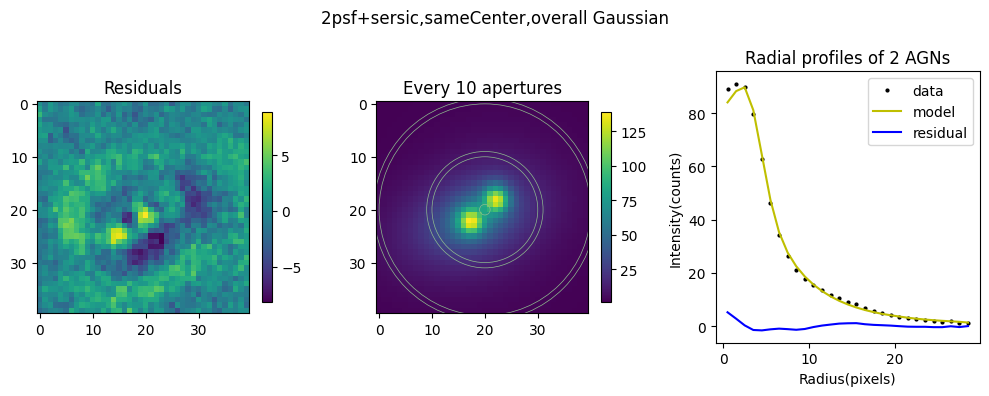

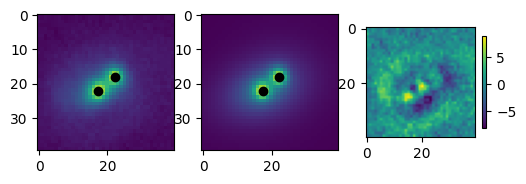

In [330]:
getResult("2psf+sersic,sameCenter,overall Gaussian", imageAGNcrop, data_center=[20,20])

In [7]:
printFitResult("2psf+gaussian,sameCenter,overall Sersic")

48.23, 57.36, 3444.90, 231.03, 0.12, 1.00, 7.81, 14.92, 53.28, 53.44, 1956.93, 83.80, 0.77, 1.00, 0.29, 46.03, 76.75, 77.01, 337.22, 0.45, 1.00, 1.44, 2.27, 

bf:  49.9442609722547
new:  108.73430082836005


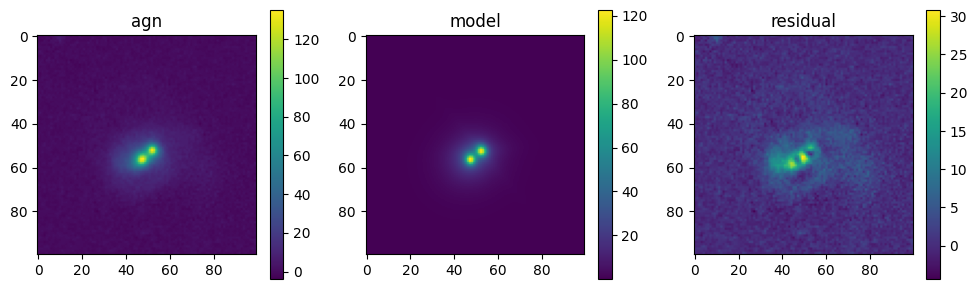

In [56]:
newp = [48.23, 57.36, 2444.90, 
        231.03, 0.12, 1.00, 7.81, 10.92, 
        53.28, 53.44, 1956.93, 
        83.80, 0.77, 1.00, 3.29, 10.03, 
        50,50, 200.22, 0.45, 1.00, 30, 40.27]
plotNewP("2psf+sersic,sameCenter,overall Sersic",newp)